# 1. Setup and Get Data

### 1.1 Install Dependencies and Setup

In [ ]:
!pip install labelme tensorflow tensorflow-gpu opencv-python matplotlib albumentations

### 1.2 Collect Images Using OpenCV

In [6]:
import os
import time
import uuid
import cv2

In [3]:
IMAGES_PATH = os.path.join('data','images')
number_images = 30

In [5]:
# cap = cv2.VideoCapture(0)
# for imgnum in range(number_images):
#     print('Collecting image {}'.format(imgnum))
#     ret, frame = cap.read()
#     imgname = os.path.join(IMAGES_PATH,f'{str(uuid.uuid1())}.jpg')
#     cv2.imwrite(imgname, frame)
#     cv2.imshow('frame', frame)
#     time.sleep(0.5)

#     if cv2.waitKey(1) & 0xFF == ord('q'):
#         break
# cap.release()
# cv2.destroyAllWindows()

### 1.3 Annotate Images with LabelMe

In [14]:
# !labelme

[INFO   ] __init__:get_config:71 - Loading config file from: /Users/arthurdesmazures/.labelmerc


# 2. Review Dataset and Build Image Loading Function

### 2.1 Import TF and Deps

In [15]:
import tensorflow as tf
import json
import numpy as np
from matplotlib import pyplot as plt

### 2.2 Limit GPU Memory Growth

In [3]:
# Avoid OOM errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)

In [4]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

### 2.3 Load Image into TF Data Pipeline

In [5]:
images = tf.data.Dataset.list_files('data/images/*.jpg')

2024-04-20 17:40:27.026891: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M3 Pro
2024-04-20 17:40:27.026916: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 18.00 GB
2024-04-20 17:40:27.026922: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 6.00 GB
2024-04-20 17:40:27.026946: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-04-20 17:40:27.026961: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


InvalidArgumentError: Expected 'tf.Tensor(False, shape=(), dtype=bool)' to be true. Summarized data: b'No files matched pattern: data/images/*.jpg'

In [3]:
images.as_numpy_iterator().next()

NameError: name 'images' is not defined

In [ ]:
def load_image(x): 
    byte_img = tf.io.read_file(x)
    img = tf.io.decode_jpeg(byte_img)
    return img

In [ ]:
images = images.map(load_image)

In [ ]:
images.as_numpy_iterator().next()

array([[[106, 109, 102],
        [104, 107, 100],
        [103, 106,  99],
        ...,
        [ 81,  83,  70],
        [ 80,  82,  69],
        [ 79,  81,  68]],

       [[104, 107, 100],
        [104, 107, 100],
        [104, 107, 100],
        ...,
        [ 81,  83,  70],
        [ 80,  82,  69],
        [ 80,  82,  69]],

       [[104, 107, 100],
        [106, 109, 102],
        [106, 109, 102],
        ...,
        [ 81,  83,  70],
        [ 80,  82,  69],
        [ 80,  82,  69]],

       ...,

       [[157, 164, 130],
        [157, 165, 128],
        [160, 167, 133],
        ...,
        [108, 117, 116],
        [108, 117, 116],
        [108, 117, 116]],

       [[168, 173, 141],
        [165, 171, 137],
        [166, 171, 139],
        ...,
        [108, 117, 116],
        [108, 117, 116],
        [108, 117, 116]],

       [[171, 176, 144],
        [167, 172, 140],
        [169, 174, 142],
        ...,
        [108, 117, 116],
        [109, 118, 117],
        [109, 118, 117]]

In [ ]:
type(images)

tensorflow.python.data.ops.map_op._MapDataset

### 2.4 View Raw Images with Matplotlib

In [ ]:
image_generator = images.batch(4).as_numpy_iterator()

In [ ]:
plot_images = image_generator.next()

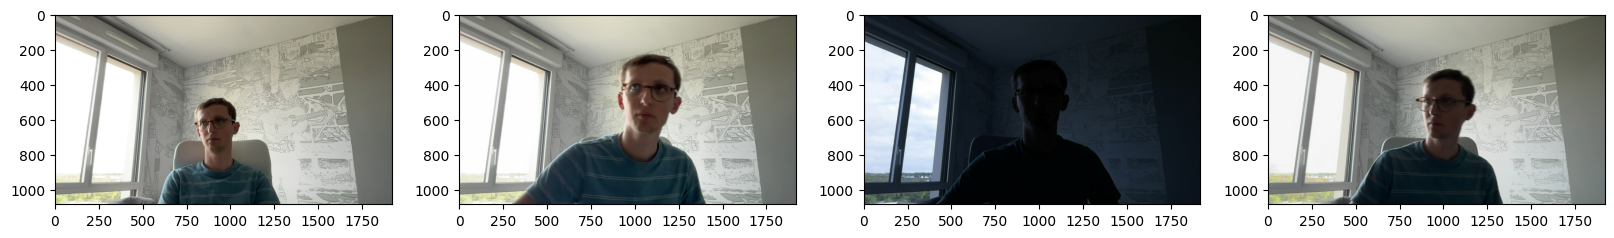

In [ ]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, image in enumerate(plot_images):
    ax[idx].imshow(image) 
plt.show()

# 3. Partition Unaugmented Data

### 3.1 MANUALLY SPLT DATA INTO TRAIN TEST AND VAL

In [118]:
90*.7 # 63 to train

62.99999999999999

In [119]:
90*.15 # 14 and 13 to test and val

13.5

### 3.2 Move the Matching Labels

In [120]:
for folder in ['train','test','val']:
    for file in os.listdir(os.path.join('data', folder, 'images')):
        
        filename = file.split('.')[0]+'.json'
        existing_filepath = os.path.join('data','labels', filename)
        if os.path.exists(existing_filepath): 
            new_filepath = os.path.join('data',folder,'labels',filename)
            os.replace(existing_filepath, new_filepath)      

# 4. Apply Image Augmentation on Images and Labels using Albumentations

### 4.1 Setup Albumentations Transform Pipeline

In [121]:
import albumentations as alb

In [122]:
# augmentor = alb.Compose([
#     alb.Resize(height=450, width=450),
#     alb.HorizontalFlip(p=0.5),
#     alb.RandomBrightnessContrast(p=0.2),
#     alb.RandomGamma(p=0.2),
#     alb.RGBShift(p=0.2),
#     alb.VerticalFlip(p=0.5)],
#     bbox_params=alb.BboxParams(format='albumentations', label_fields=['class_labels']))


### 4.2 Load a Test Image and Annotation with OpenCV and JSON

In [123]:
img = cv2.imread(os.path.join('data','test', 'images','b8785bd4-ff27-11ee-bfc0-ae6d906d4950.jpg'))

In [124]:
img.shape

(1080, 1920, 3)

In [125]:
with open(os.path.join('data', 'test', 'labels', 'b8785bd4-ff27-11ee-bfc0-ae6d906d4950.json'), 'r') as f:
    label = json.load(f)

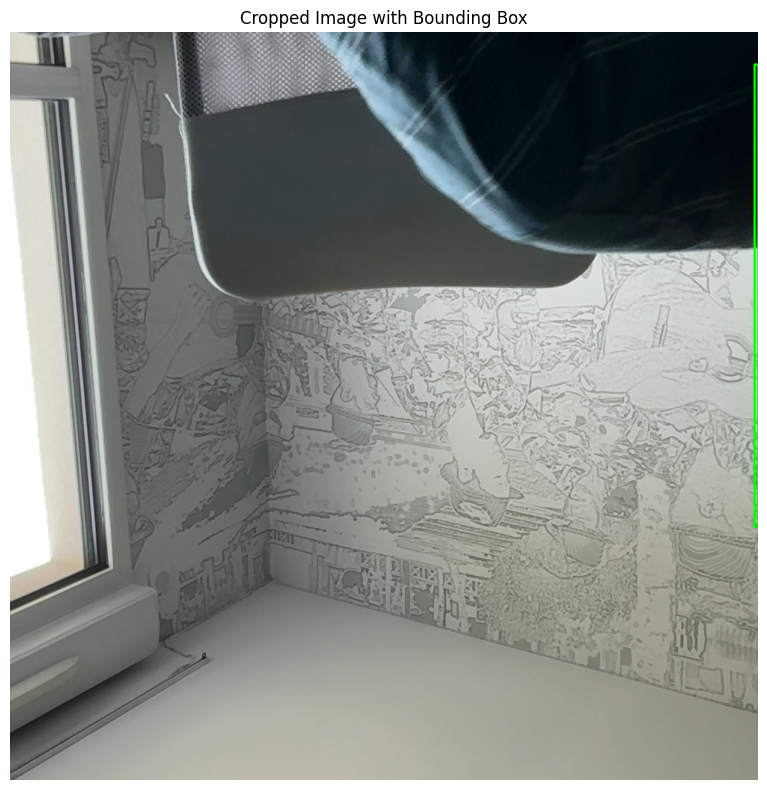

In [126]:
import cv2
import albumentations as A
import matplotlib.pyplot as plt

# Extract the bounding box coordinates
x_min, y_min = label['shapes'][0]['points'][0]
x_max, y_max = label['shapes'][0]['points'][1]

# Get the image dimensions
height, width = img.shape[:2]

# Normalize the bounding box coordinates to the range [0.0, 1.0]
bbox = [x_min / width, y_min / height, x_max / width, y_max / height]

transform = A.Compose([
    A.RandomCrop(width=1000, height=1000),
    alb.HorizontalFlip(p=0.5), 
    alb.RandomBrightnessContrast(p=0.2),
    alb.RandomGamma(p=0.2), 
    alb.RGBShift(p=0.2), 
    alb.VerticalFlip(p=0.5)
], bbox_params=A.BboxParams(format='albumentations', label_fields=['class_labels']))

transformed = transform(image=img, bboxes=[bbox], class_labels=['face'])

cropped_img = transformed['image']
cropped_labels = transformed['bboxes']

# Convert the cropped image from BGR to RGB color space
cropped_img_rgb = cv2.cvtColor(cropped_img, cv2.COLOR_BGR2RGB)

# Extract the cropped bounding box coordinates
if cropped_labels:
    x_min, y_min, x_max, y_max = cropped_labels[0]

    # Convert the normalized coordinates back to pixel values
    x_min = int(x_min * 1000)
    y_min = int(y_min * 1000)
    x_max = int(x_max * 1000)
    y_max = int(y_max * 1000)

    # Draw the cropped bounding box on the cropped image
    cv2.rectangle(cropped_img_rgb, (x_min, y_min), (x_max, y_max), (0, 255, 0), 2)

# Display the cropped image with the bounding box using Matplotlib
plt.figure(figsize=(8, 8))
plt.imshow(cropped_img_rgb)
plt.axis('off')
plt.title('Cropped Image with Bounding Box')
plt.tight_layout()
plt.show()


# 5. Build and Run Augmentation Pipeline

### 5.1 Run Augmentation Pipeline

In [127]:
for partition in ['train','test','val']: 
    for image in os.listdir(os.path.join('data', partition, 'images')):
        img = cv2.imread(os.path.join('data', partition, 'images', image))

        coords = [0,0,0.00001,0.00001]
        label_path = os.path.join('data', partition, 'labels', f'{image.split(".")[0]}.json')
        if os.path.exists(label_path):
            with open(label_path, 'r') as f:
                label = json.load(f)

            # Extract the bounding box coordinates
            x_min, y_min = label['shapes'][0]['points'][0]
            x_max, y_max = label['shapes'][0]['points'][1]

            # Get the image dimensions
            height, width = img.shape[:2]

            # Normalize the bounding box coordinates to the range [0.0, 1.0]
            bbox = [x_min / width, y_min / height, x_max / width, y_max / height]

        try: 
            for x in range(1):
                augmented = transform(image=img, bboxes=[bbox], class_labels=['face'])
                cv2.imwrite(os.path.join('aug_data', partition, 'images', f'{image.split(".")[0]}.{x}.jpg'), augmented['image'])

                annotation = {}
                annotation['image'] = image

                if os.path.exists(label_path):
                    if len(augmented['bboxes']) == 0: 
                        annotation['bbox'] = [0,0,0,0]
                        annotation['class'] = 0 
                    else: 
                        annotation['bbox'] = augmented['bboxes'][0]
                        annotation['class'] = 1
                else: 
                    annotation['bbox'] = [0,0,0,0]
                    annotation['class'] = 0 


                with open(os.path.join('aug_data', partition, 'labels', f'{image.split(".")[0]}.{x}.json'), 'w') as f:
                    json.dump(annotation, f)

        except Exception as e:
            print(e)

x_max is less than or equal to x_min for bbox [0.5452445652173913, 0.6482286634460548, 0.31426630434782604, 0.19130434782608693, 'face'].
x_max is less than or equal to x_min for bbox [0.5452445652173913, 0.6482286634460548, 0.31426630434782604, 0.19130434782608693, 'face'].
image must be numpy array type
image must be numpy array type
image must be numpy array type


### 5.2 Load Augmented Images to Tensorflow Dataset

In [128]:
def load_image(x): 
    byte_img = tf.io.read_file(x)
    img = tf.io.decode_jpeg(byte_img)
    return img

In [129]:
train_images = tf.data.Dataset.list_files('aug_data/train/images/*.jpg', shuffle=False)
train_images = train_images.map(load_image)
train_images = train_images.map(lambda x: tf.image.resize(x, (120,120)))
train_images = train_images.map(lambda x: x/255)

In [130]:
test_images = tf.data.Dataset.list_files('aug_data/test/images/*.jpg', shuffle=False)
test_images = test_images.map(load_image)
test_images = test_images.map(lambda x: tf.image.resize(x, (120,120)))
test_images = test_images.map(lambda x: x/255)

In [131]:
val_images = tf.data.Dataset.list_files('aug_data/val/images/*.jpg', shuffle=False)
val_images = val_images.map(load_image)
val_images = val_images.map(lambda x: tf.image.resize(x, (120,120)))
val_images = val_images.map(lambda x: x/255)

In [132]:
train_images.as_numpy_iterator().next()

array([[[0.46971676, 0.4732026 , 0.4614379 ],
        [0.50980395, 0.5111111 , 0.49150324],
        [0.44923747, 0.45315903, 0.42962962],
        ...,
        [0.6819173 , 0.68845326, 0.624401  ],
        [0.6888889 , 0.68496734, 0.6143791 ],
        [0.6867102 , 0.68366003, 0.6078429 ]],

       [[0.5294118 , 0.5294118 , 0.52156866],
        [0.5019608 , 0.50980395, 0.49803922],
        [0.3202614 , 0.32418296, 0.30457512],
        ...,
        [0.68235296, 0.6862745 , 0.6156863 ],
        [0.69411767, 0.68235296, 0.6156863 ],
        [0.6862745 , 0.68235296, 0.6065358 ]],

       [[0.47320265, 0.47320265, 0.4653595 ],
        [0.49934638, 0.49934638, 0.49150324],
        [0.45969492, 0.45969492, 0.4518518 ],
        ...,
        [0.6901961 , 0.6784314 , 0.6039216 ],
        [0.6901961 , 0.6784314 , 0.6039216 ],
        [0.6901961 , 0.6784314 , 0.6117647 ]],

       ...,

       [[0.58562106, 0.5934642 , 0.5886711 ],
        [0.5882353 , 0.5882353 , 0.5882353 ],
        [0.58431375, 0

# 6. Prepare Labels

### 6.1 Build Label Loading Function

In [133]:
def load_labels(label_path):
    with open(label_path.numpy(), 'r', encoding = "utf-8") as f:
        label = json.load(f)
        
    return [label['class']], label['bbox']

### 6.2 Load Labels to Tensorflow Dataset

In [134]:
train_labels = tf.data.Dataset.list_files('aug_data/train/labels/*.json', shuffle=False)
train_labels = train_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

In [135]:
test_labels = tf.data.Dataset.list_files('aug_data/test/labels/*.json', shuffle=False)
test_labels = test_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

In [136]:
val_labels = tf.data.Dataset.list_files('aug_data/val/labels/*.json', shuffle=False)
val_labels = val_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

In [137]:
train_labels.as_numpy_iterator().next()

(array([1], dtype=uint8),
 array([0.4155, 0.2242, 0.818 , 0.6807], dtype=float16))

# 7. Combine Label and Image Samples

### 7.1 Check Partition Lengths

In [138]:
len(train_images), len(train_labels), len(test_images), len(test_labels), len(val_images), len(val_labels)

(17, 17, 4, 4, 7, 7)

### 7.2 Create Final Datasets (Images/Labels)

In [139]:
train = tf.data.Dataset.zip((train_images, train_labels))
train = train.shuffle(5000)
train = train.batch(8)
train = train.prefetch(4)

In [140]:
test = tf.data.Dataset.zip((test_images, test_labels))
test = test.shuffle(1300)
test = test.batch(8)
test = test.prefetch(4)

In [141]:
val = tf.data.Dataset.zip((val_images, val_labels))
val = val.shuffle(1000)
val = val.batch(8)
val = val.prefetch(4)

In [142]:
train.as_numpy_iterator().next()[1]

(array([[1],
        [0],
        [1],
        [0],
        [1],
        [1],
        [1],
        [0]], dtype=uint8),
 array([[0.3523, 0.259 , 0.726 , 0.672 ],
        [0.    , 0.    , 0.    , 0.    ],
        [0.1606, 0.2369, 0.515 , 0.6694],
        [0.    , 0.    , 0.    , 0.    ],
        [0.2382, 0.3867, 0.562 , 0.7563],
        [0.    , 0.2612, 0.2009, 0.785 ],
        [0.6475, 0.253 , 0.9995, 0.6484],
        [0.    , 0.    , 0.    , 0.    ]], dtype=float16))

### 7.3 View Images and Annotations

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


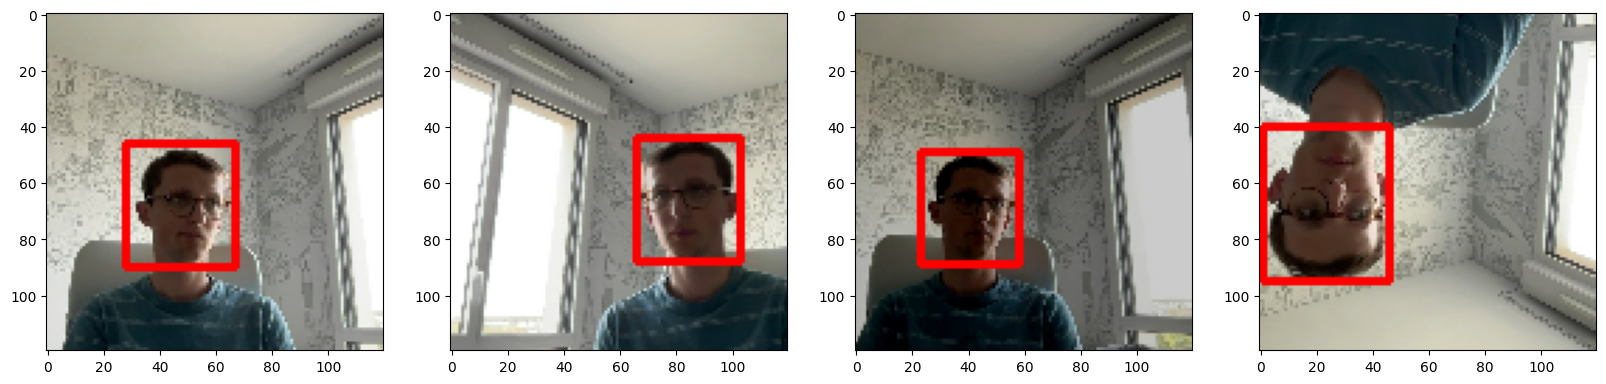

In [143]:
data_samples = train.as_numpy_iterator()
res = data_samples.next()

fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx in range(4): 
    sample_image = res[0][idx]
    sample_coords = res[1][1][idx]
    
    # Create a copy of the sample_image
    sample_image_copy = np.copy(sample_image)
    
    cv2.rectangle(sample_image_copy, 
                  tuple(np.multiply(sample_coords[:2], [120,120]).astype(int)),
                  tuple(np.multiply(sample_coords[2:], [120,120]).astype(int)), 
                        (255,0,0), 2)

    ax[idx].imshow(sample_image_copy)


# 8. Build Deep Learning using the Functional API

### 8.1 Import Layers and Base Network

In [144]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, Dense, GlobalMaxPooling2D
from tensorflow.keras.applications import VGG16

### 8.2 Download VGG16

In [145]:
vgg = VGG16(include_top=False)

In [146]:
vgg.summary()

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_7 (InputLayer)      │ (None, None, None, 3)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, None, None, 64) │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, None, None, 64) │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, None, None, 64) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, None, None,     │        73,856 │
│                                 │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, None, None,     │       147,584 │
│                                 │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, None, None,     │             0 │
│                                 │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, None, None,     │       295,168 │
│                                 │ 256)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, None, None,     │       590,080 │
│                                 │ 256)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, None, None,     │       590,080 │
│                                 │ 256)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, None, None,     │             0 │
│                                 │ 256)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, None, None,     │     1,180,160 │
│                                 │ 512)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, None, None,     │     2,359,808 │
│                                 │ 512)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, None, None,     │     2,359,808 │
│                                 │ 512)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, None, None,     │             0 │
│                                 │ 512)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, None, None,     │     2,359,808 │
│                                 │ 512)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, None, None,     │     2,359,808 │
│                                 │ 512)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, None, None,     │     2,359,808 │
│                                 │ 512)                   │             

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 14,714,688 (56.13 MB)

 Non-trainable params: 0 (0.00 B)

### 8.3 Build instance of Network

In [147]:
def build_model(): 
    input_layer = Input(shape=(120,120,3))
    
    vgg = VGG16(include_top=False)(input_layer)

    # Classification Model  
    f1 = GlobalMaxPooling2D()(vgg)
    class1 = Dense(2048, activation='relu')(f1)
    class2 = Dense(1, activation='sigmoid')(class1)
    
    # Bounding box model
    f2 = GlobalMaxPooling2D()(vgg)
    regress1 = Dense(2048, activation='relu')(f2)
    regress2 = Dense(4, activation='sigmoid')(regress1)
    
    facetracker = Model(inputs=input_layer, outputs=[class2, regress2])
    return facetracker

In [148]:
train.as_numpy_iterator().next()[1]

(array([[1],
        [0],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1]], dtype=uint8),
 array([[0.4155 , 0.2242 , 0.818  , 0.6807 ],
        [0.     , 0.     , 0.     , 0.     ],
        [0.     , 0.218  , 0.281  , 0.6855 ],
        [0.02396, 0.3276 , 0.3784 , 0.8145 ],
        [0.3467 , 0.2424 , 0.6597 , 0.686  ],
        [0.507  , 0.2847 , 0.822  , 0.639  ],
        [0.     , 0.2612 , 0.2009 , 0.785  ],
        [0.6475 , 0.253  , 0.9995 , 0.6484 ]], dtype=float16))

### 8.4 Test out Neural Network

In [149]:
facetracker = build_model()

In [150]:
facetracker.summary()

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_8       │ (None, 120, 120,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ vgg16 (Functional)  │ (None, 3, 3, 512) │ 14,714,688 │ input_layer_8[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 512)       │          0 │ vgg16[0][0]       │
│ (GlobalMaxPooling2… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 512)       │          0 │ vgg16[0][0]       │
│ (GlobalMaxPooling2… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_8 (Dense)     │ (None, 2048)      │  1,050,624 │ global_max_pooli… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_10 (Dense)    │ (None, 2048)      │  1,050,624 │ global_max_pooli… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_9 (Dense)     │ (None, 1)         │      2,049 │ dense_8[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_11 (Dense)    │ (None, 4)         │      8,196 │ dense_10[0][0]    │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 16,826,181 (64.19 MB)

 Trainable params: 16,826,181 (64.19 MB)

 Non-trainable params: 0 (0.00 B)

In [151]:
X, y = train.as_numpy_iterator().next()

In [152]:
X.shape

(8, 120, 120, 3)

In [153]:
classes, coords = facetracker.predict(X)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


In [154]:
classes, coords

(array([[0.27017832],
        [0.21448092],
        [0.2078753 ],
        [0.26230603],
        [0.19012007],
        [0.3143062 ],
        [0.2752167 ],
        [0.23216715]], dtype=float32),
 array([[0.7758961 , 0.4444904 , 0.5401626 , 0.4033766 ],
        [0.7848157 , 0.43764496, 0.3565848 , 0.45938122],
        [0.7853459 , 0.37801063, 0.5055633 , 0.40234065],
        [0.7934957 , 0.48087454, 0.39233017, 0.4082147 ],
        [0.76404405, 0.47758508, 0.4033579 , 0.38830334],
        [0.7350115 , 0.4640758 , 0.49437526, 0.50005144],
        [0.7365246 , 0.43369636, 0.39224645, 0.41231385],
        [0.72694767, 0.3913105 , 0.54214084, 0.44278717]], dtype=float32))

# 9. Define Losses and Optimizers

### 9.1 Define Optimizer and LR

In [155]:
batches_per_epoch = len(train)
lr_decay = (1./0.75 -1)/batches_per_epoch

In [156]:
opt = tf.keras.optimizers.Adam(learning_rate=0.0001, decay=lr_decay)

### 9.2 Create Localization Loss and Classification Loss

In [157]:
def localization_loss(y_true, yhat):            
    delta_coord = tf.reduce_sum(tf.square(y_true[:,:2] - yhat[:,:2]))
                  
    h_true = y_true[:,3] - y_true[:,1] 
    w_true = y_true[:,2] - y_true[:,0] 

    h_pred = yhat[:,3] - yhat[:,1] 
    w_pred = yhat[:,2] - yhat[:,0] 
    
    delta_size = tf.reduce_sum(tf.square(w_true - w_pred) + tf.square(h_true-h_pred))
    
    return delta_coord + delta_size

In [158]:
classloss = tf.keras.losses.BinaryCrossentropy()
regressloss = localization_loss

### 9.3 Test out Loss Metrics

In [159]:
localization_loss(y[1], coords)

<tf.Tensor: shape=(), dtype=float32, numpy=7.968107>

In [160]:
classloss(y[0], classes)

<tf.Tensor: shape=(), dtype=float32, numpy=1.3181481>

In [161]:
regressloss(y[1], coords)

<tf.Tensor: shape=(), dtype=float32, numpy=7.968107>

# 10. Train Neural Network

### 10.1 Create Custom Model Class

In [214]:
class FaceTracker(Model):
    def __init__(self, eyetracker, **kwargs):
        super().__init__(**kwargs)
        self.model = eyetracker

    def compile(self, opt, classloss, localizationloss, **kwargs):
        super().compile(**kwargs)
        self.closs = classloss
        self.lloss = localizationloss
        self.opt = opt

    def train_step(self, batch, **kwargs):
        X, y = batch

        with tf.GradientTape() as tape:
            classes, coords = self.model(X, training=True)
            batch_classloss = self.closs(y[0], classes)
            batch_localizationloss = self.lloss(tf.cast(y[1], tf.float32), coords)
            total_loss = batch_localizationloss + 0.5 * batch_classloss
            grad = tape.gradient(total_loss, self.model.trainable_variables)
        self.opt.apply_gradients(zip(grad, self.model.trainable_variables))

        return {"total_loss": total_loss, "class_loss": batch_classloss, "regress_loss": batch_localizationloss}

    def test_step(self, batch, **kwargs):
        X, y = batch
        classes, coords = self.model(X, training=False)
        batch_classloss = self.closs(y[0], classes)
        batch_localizationloss = self.lloss(tf.cast(y[1], tf.float32), coords)
        total_loss = batch_localizationloss + 0.5 * batch_classloss

        return {"total_loss": total_loss, "class_loss": batch_classloss, "regress_loss": batch_localizationloss}

    def call(self, X, **kwargs):
        return self.model(X, **kwargs)



In [215]:
model = FaceTracker(facetracker)

In [216]:
model.compile(opt, classloss, regressloss)

### 10.2 Train

In [217]:
logdir='logs'

In [218]:
# tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [219]:
hist = model.fit(train, epochs=10, validation_data=val)

Epoch 1/10


ValueError: Cannot take the length of shape with unknown rank.

### 10.3 Plot Performance

In [ ]:
hist.history

In [ ]:
fig, ax = plt.subplots(ncols=3, figsize=(20,5))

ax[0].plot(hist.history['total_loss'], color='teal', label='loss')
ax[0].plot(hist.history['val_total_loss'], color='orange', label='val loss')
ax[0].title.set_text('Loss')
ax[0].legend()

ax[1].plot(hist.history['class_loss'], color='teal', label='class loss')
ax[1].plot(hist.history['val_class_loss'], color='orange', label='val class loss')
ax[1].title.set_text('Classification Loss')
ax[1].legend()

ax[2].plot(hist.history['regress_loss'], color='teal', label='regress loss')
ax[2].plot(hist.history['val_regress_loss'], color='orange', label='val regress loss')
ax[2].title.set_text('Regression Loss')
ax[2].legend()

plt.show()

# 11. Make Predictions

### 11.1 Make Predictions on Test Set

In [ ]:
test_data = test.as_numpy_iterator()

In [ ]:
test_sample = test_data.next()

In [ ]:
yhat = facetracker.predict(test_sample[0])

In [ ]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx in range(4): 
    sample_image = test_sample[0][idx]
    sample_coords = yhat[1][idx]
    
    if yhat[0][idx] > 0.9:
        cv2.rectangle(sample_image, 
                      tuple(np.multiply(sample_coords[:2], [120,120]).astype(int)),
                      tuple(np.multiply(sample_coords[2:], [120,120]).astype(int)), 
                            (255,0,0), 2)
    
    ax[idx].imshow(sample_image)

### 11.2 Save the Model

In [ ]:
from tensorflow.keras.models import load_model

In [ ]:
facetracker.save('facetracker.h5')

In [ ]:
facetracker = load_model('facetracker.h5')

### 11.3 Real Time Detection

In [ ]:
cap = cv2.VideoCapture(1)
while cap.isOpened():
    _ , frame = cap.read()
    frame = frame[50:500, 50:500,:]
    
    rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    resized = tf.image.resize(rgb, (120,120))
    
    yhat = facetracker.predict(np.expand_dims(resized/255,0))
    sample_coords = yhat[1][0]
    
    if yhat[0] > 0.5: 
        # Controls the main rectangle
        cv2.rectangle(frame, 
                      tuple(np.multiply(sample_coords[:2], [450,450]).astype(int)),
                      tuple(np.multiply(sample_coords[2:], [450,450]).astype(int)), 
                            (255,0,0), 2)
        # Controls the label rectangle
        cv2.rectangle(frame, 
                      tuple(np.add(np.multiply(sample_coords[:2], [450,450]).astype(int), 
                                    [0,-30])),
                      tuple(np.add(np.multiply(sample_coords[:2], [450,450]).astype(int),
                                    [80,0])), 
                            (255,0,0), -1)
        
        # Controls the text rendered
        cv2.putText(frame, 'face', tuple(np.add(np.multiply(sample_coords[:2], [450,450]).astype(int),
                                               [0,-5])),
                    cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2, cv2.LINE_AA)
    
    cv2.imshow('EyeTrack', frame)
    
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()